### Task IV: Quantum Generative Adversarial Network (QGAN)

You will explore how best to apply a quantum generative adversarial network (QGAN) to solve a High Energy Data analysis issue, more specifically, separating the signal events from the background events. You should use the Google Cirq and Tensorflow Quantum (TFQ) libraries for this task. 

A set of input samples (simulated with Delphes) is provided in NumPy NPZ format [Download Input]. In the input file, there are only 100 samples for training and 100 samples for testing so it won’t take much computing resources to accomplish this 
task. The signal events are labeled with 1 while the background events are labeled with 0. 
Be sure to show that you understand how to fine tune your machine learning model to improve the performance. The performance can be evaluated with classification accuracy or Area Under ROC Curve (AUC). 


In [6]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import numpy as np

In [71]:
data = np.load('data/QIS_EXAM_200Events.npz', allow_pickle=True)
X_train=data['training_input'].item()
X_test=data['test_input'].item()

X_train_0 = X_train['0']
X_train_1 = X_train['1']
X_test_0 = X_test['0']
X_test_1 = X_test['1']

X_train = np.concatenate((X_train_0,X_train_1),axis=0)
X_test = np.concatenate((X_test_0,X_test_1),axis=0)

y_train = np.zeros((len(X_train),1))
y_train[len(X_train_0):] = 1
y_test = np.zeros((len(X_test),))
y_test[len(X_test_0):] = 1

y_train = tf.keras.utils.to_categorical(y_train)*2-1
y_test = tf.keras.utils.to_categorical(y_test)*2-1

y_train_hinge = np.concatenate((y_train, np.ones((len(y_train), 1))), axis=1)
y_test_hinge = np.concatenate((y_test, np.ones((len(y_test), 1))), axis=1)


print(X_train[:5])
print(y_train_hinge[:5])

print(X_train.shape, y_train_hinge.shape)
print(X_test.shape, y_test_hinge.shape)

[[-0.43079088  0.86834819 -0.92614721 -0.92662029 -0.56900862]
 [ 0.33924198  0.56155499  0.93097459 -0.91631726 -0.54463516]
 [-0.42888879  0.87064961 -0.92782179 -0.77533991 -0.58329176]
 [-0.43262871  0.86128919 -0.92240878 -0.88048862 -0.49963115]
 [-0.99925345 -0.99949586  0.07753685 -0.84218034 -0.5149399 ]]
[[ 1. -1.  1.]
 [ 1. -1.  1.]
 [ 1. -1.  1.]
 [ 1. -1.  1.]
 [ 1. -1.  1.]]
(100, 5) (100, 3)
(100, 5) (100, 3)


(0, 0): ───X^(RY1:0)───Y^(RX1:0)───Z^(RZ1:0)───@───────────────────────
                                               │
(0, 1): ───X^(RY1:1)───Y^(RX1:1)───Z^(RZ1:1)───X───@───────────────────
                                                   │
(0, 2): ───X^(RY1:2)───Y^(RX1:2)───Z^(RZ1:2)───────X───@───────────────
                                                       │
(0, 3): ───X^(RY1:3)───Y^(RX1:3)───Z^(RZ1:3)───────────X───@───────────
                                                           │
(0, 4): ───X^(RY1:4)───Y^(RX1:4)───Z^(RZ1:4)───────────────X───@───────
                                                               │
0: ────────────────────────────────────────────────────────────X───H───
Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None,)]                 0         
                                                                 
 

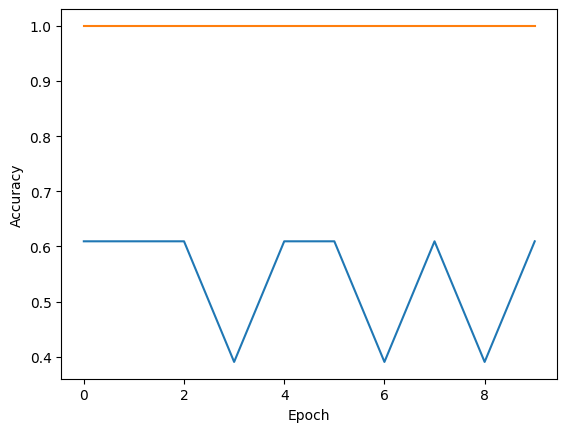

In [34]:
import tensorflow as tf
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt
import cirq
import sympy

def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

def convert_to_circuit(values):
    """Converts the input data into a quantum circuit."""
    qubits = cirq.GridQubit.rect(1, len(values))
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit

class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix, entangle_readout=True):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + ':' + str(i))
            # Modify Logic here
            if entangle_readout:
                circuit.append(gate(qubit, self.readout)**symbol)
            else:
                # circuit.append(gate(symbol)(qubit))
                circuit.append(gate(qubit)**symbol)
            

def create_quantum_circuit(qubits, readout):
    circuit = cirq.Circuit()
    builder = CircuitLayerBuilder(data_qubits=qubits, readout=readout)
    
    # Adding layers
    # builder.add_layer(circuit, gate=cirq.XX, prefix=f'XX0')
    builder.add_layer(circuit, gate=cirq.X, prefix=f'RY1', entangle_readout=False)
    builder.add_layer(circuit, gate=cirq.Y, prefix=f'RX1', entangle_readout=False)
    builder.add_layer(circuit, gate=cirq.Z, prefix=f'RZ1', entangle_readout=False)
    # builder.add_layer(circuit, gate=cirq.ZZ, prefix=f'ZZ2')
    # builder.add_layer(circuit, gate=cirq.rz, prefix=f'rz{layer}')
    # Adding entanglement
    for i in range(len(qubits)-1):
        circuit.append(cirq.CNOT(qubits[i], qubits[i+1]))
    circuit.append(cirq.CNOT(qubits[-1], readout))
    circuit.append(cirq.H(readout))
    return circuit, cirq.Z(readout)

# Adjust the layer in quantum layer creation
def create_quantum_model(qubits, readout):
    data_input = tf.keras.Input(shape = (), dtype = tf.dtypes.string)
    
    model_circuit, model_readout = create_quantum_circuit(qubits, readout)
    print(model_circuit)
    
    quantum_layer = tfq.layers.PQC(model_circuit, model_readout)(data_input)
    
    model = tf.keras.Model(inputs = [data_input], outputs = [quantum_layer])
    
    return model

qubits = cirq.GridQubit.rect(1, 5)  # Define 5 qubits
readout = cirq.LineQubit(0)
qnn_model = create_quantum_model(qubits, readout)

# Compile, fit, evaluate model as before
qnn_model.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss=tf.keras.losses.Hinge(), 
                  metrics=[hinge_accuracy])

qnn_model.summary()


X_train_circuits = [convert_to_circuit(x) for x in X_train]
X_test_circuits = [convert_to_circuit(x) for x in X_test]

# Note: Make sure y_train and y_test are properly defined and preprocessed
history = qnn_model.fit(tfq.convert_to_tensor(X_train_circuits), y_train_hinge, 
              batch_size=32, verbose=1, epochs=10, 
              validation_data=(tfq.convert_to_tensor(X_test_circuits), y_test_hinge))

print(history.history)
plt.plot(history.history['val_hinge_accuracy'])
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Correct the evaluate call to use the quantum tensor format
test_loss, test_accuracy = qnn_model.evaluate(tfq.convert_to_tensor(X_test_circuits), y_test_hinge)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)


In [83]:
import cirq
import sympy
import numpy as np

def add_one_qubit_unitary(circuit, qubits, prefix, params):
    if params is None:
        for i, qubit in enumerate(qubits):
            circuit.append(cirq.X(qubit)**sympy.Symbol(f'{prefix}_{3*i}'))
            circuit.append(cirq.Y(qubit)**sympy.Symbol(f'{prefix}_{3*i+1}'))
            circuit.append(cirq.Z(qubit)**sympy.Symbol(f'{prefix}_{3*i+2}'))
    else:   
        for i, qubit in enumerate(qubits):
            circuit.append(cirq.X(qubit)**params[3*i])
            circuit.append(cirq.Y(qubit)**params[3*i+1])
            circuit.append(cirq.Z(qubit)**params[3*i+2])

def add_entangling_layer(circuit, qubits):
    for i in range(len(qubits) - 1):
        circuit.append(cirq.CNOT(qubits[i], qubits[i + 1]))

def generator(gen_qubits, data_qubits, layer, init_weights=None):
    circuit = cirq.Circuit()
    
    qubits = gen_qubits + data_qubits
    
    # Apply RY gates with random angles to the first half of qubits
    random_angles = np.random.normal(loc=0, scale=np.pi/3, size=len(qubits))
    for i, angle in enumerate(random_angles):
        circuit.append(cirq.ry(angle)(qubits[i]))

    # Add layers
    params = None
    for i in range(layer):
        if init_weights is not None:
            params = init_weights[3*len(qubits)*i:3*len(qubits)*(i+1)]
        add_one_qubit_unitary(circuit, qubits, f'gen_{i}', params)
        add_entangling_layer(circuit, qubits)
    
    if init_weights is not None:
        params = init_weights[-3*len(output_qubits):]

    add_one_qubit_unitary(circuit, data_qubits, f'gen_out', params)
    
    return circuit

def discriminator(data_qubits, output_qubits, layer, init_weights=None):
    circuit = cirq.Circuit()
    qubits = data_qubits + output_qubits

    # Hadamard layer for data qubits
    for qubit in data_qubits:
        circuit.append(cirq.H(qubit))

    # Add layers
    params = None
    for i in range(layer):
        if init_weights is not None:
            params = init_weights[3*len(qubits)*i:3*len(qubits)*(i+1)]
        add_one_qubit_unitary(circuit, qubits, f'disc_{i}', params)
        add_entangling_layer(circuit, qubits)
        
    if init_weights is not None:
        params = init_weights[-3*len(output_qubits):]
        
    add_one_qubit_unitary(circuit, output_qubits, f'disc_out', params)
    # if init_weights is not None:
    #     for i in range(layer):
    #         values = init_weights[3*len(qubits)*i:3*len(qubits)*(i+1)]
    #         add_one_qubit_unitary(circuit, qubits, values)
    #         add_entangling_layer(circuit, qubits)
            
    #     add_one_qubit_unitary(circuit, output_qubits, init_weights[-3*len(output_qubits):])
        
    # else:
    #     for i in range(layer):
    #         add_one_qubit_unitary(circuit, qubits, f'disc_{i}')
    #         add_entangling_layer(circuit, qubits)
            
    #     add_one_qubit_unitary(circuit, output_qubits, f'disc_out')

    return circuit


def create_gen_disc_circuit(qubits, num_features, num_classes, gen_layer, disc_layer, init_weights=None):
    gen_disc_circuit = cirq.Circuit()

    # Assuming the division of qubits for generator and discriminator is predefined
    gen_qubits = qubits[:num_features]
    data_qubits = qubits[num_features:-(num_classes+1)]  # Adjust as necessary
    output_qubits = qubits[-(num_classes+1):]

    # Add the generator and discriminator circuits
    gen_disc_circuit += generator(gen_qubits, data_qubits, gen_layer)
    gen_disc_circuit += discriminator(data_qubits, output_qubits, disc_layer, init_weights)

    return gen_disc_circuit


In [84]:
# Create the circuit
qubits = cirq.GridQubit.rect(1, 13)
num_features = 5  # Assuming 5 qubits for generator/data
num_classes = 2  # Assuming 3 qubits for discriminator output
gen_layer = 2
disc_layer = 2

gen_disc_circuit = create_gen_disc_circuit(qubits, num_features, num_classes, gen_layer, disc_layer)
print(gen_disc_circuit)

(0, 0): ────Ry(-0.628π)───X^gen_0_0────Y^gen_0_1────Z^gen_0_2────@───X^gen_1_0───Y^gen_1_1───Z^gen_1_2───────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                 │                                                   │
(0, 1): ────Ry(-0.232π)───X^gen_0_3────Y^gen_0_4────Z^gen_0_5────X───@───────────X^gen_1_3───Y^gen_1_4───Z^gen_1_5───X────────────@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [85]:
import tensorflow as tf
import tensorflow_quantum as tfq

alpha_weight = 0.50  # Weight for the classifier loss

@tf.function
def disc_loss(y_true, y_pred):
    D_true, D_pred = (y_true[:, 2] + 1) / 2, (y_pred[:, 2] + 1) / 2
    D_loss = tf.reduce_mean(-1 * (tf.math.log(D_pred + 1e-10) * D_true + tf.math.log(1 - D_pred + 1e-10) * (1 - D_true)))
    C_true, C_pred = (y_true[:, :2] + 1) / 2, (y_pred[:, :2] + 1) / 2
    D_true_size = tf.cast(tf.size(tf.where(D_true == 1)), dtype=tf.float32) + 1e-10
    C_loss = tf.reduce_sum(tf.keras.losses.CategoricalCrossentropy(reduction='none')(C_true, C_pred) * D_true) / D_true_size
    return (1 - alpha_weight) * D_loss + alpha_weight * C_loss

@tf.function
def custom_accuracy(y_true, y_pred):
    D_true = (y_true[:, 2] + 1) / 2
    C_real_true, C_real_pred = tf.math.argmax((y_true[:, :2] + 1) / 2, axis=1), tf.math.argmax((y_pred[:, :2] + 1) / 2, axis=1)
    same = tf.cast(C_real_true == C_real_pred, tf.float32) * D_true
    D_true_size = tf.cast(tf.size(tf.where(D_true == 1)), dtype=tf.float32) + 1e-10
    return tf.reduce_sum(same) / D_true_size


def gen_loss(y_true, y_pred):
    y_pred = (y_pred + 1) / 2
    return tf.reduce_mean((-1) * tf.math.log(y_pred + 1e-10), axis=0)

def generate_identity(X):
    return [cirq.Circuit() for _ in X]

def generate_data(X, qubits):
    quantum_data = []
    for sample in X:
        circuit = cirq.Circuit([cirq.ry(sample[bit])(qubits[bit]) for bit in range(len(sample))])
        quantum_data.append(circuit)
    return quantum_data

def checkpoints(cycle):
    gen_model_cp = tf.keras.callbacks.ModelCheckpoint(filepath='./model_save/cp_generator1_' + str(cycle) + '.h5', save_weights_only=True, monitor='loss', mode='min', save_best_only=True)
    disc_model_cp = tf.keras.callbacks.ModelCheckpoint(filepath='./model_save/cp_disc1_' + str(cycle) + '.h5', save_weights_only=True, monitor='custom_accuracy', mode='max', save_best_only=True)
    return gen_model_cp, disc_model_cp

def train_qgen(epochs, batch, verbose):
    return qgen_model.fit(x=identity_data, y=identity_label, batch_size=batch, epochs=epochs, verbose=verbose)

def train_qdisc(epochs, batch, verbose, disc_model_cp, gen_data_train, y_gen_train, gen_data_test, y_gen_test):
    return qdisc_model.fit(x=gen_data_train, y=y_gen_train, batch_size=batch, epochs=epochs, verbose=verbose, callbacks=[disc_model_cp], validation_data=(gen_data_test, y_gen_test))


In [86]:
def discriminator_model(qubits, disc_layer):
    disc_readout_operators = [cirq.Z(qubits[-(num_classes+1) + q]) for q in range(num_classes+1)]
    
    data_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

    pqc = tfq.layers.PQC(discriminator(qubits[num_features:-(num_classes+1)], qubits[-(num_classes+1):], disc_layer), disc_readout_operators)(data_input)
    
    # Define and compile the model
    model = tf.keras.Model(inputs=[data_input], outputs=[pqc])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=disc_loss,
                  metrics=[custom_accuracy])
    
    return model

def generator_model(qubits, gen_layer, init_weights):
    gen_readout_operators = [cirq.Z(qubits[-1])] 
    
    data_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

    pqc = tfq.layers.PQC(create_gen_disc_circuit(qubits, num_features, num_classes, gen_layer, disc_layer, init_weights=init_weights), gen_readout_operators)(data_input)
    
    model = tf.keras.Model(inputs=[data_input], outputs=[pqc])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=gen_loss)
    
    return model

In [87]:
qdisc_model = discriminator_model(qubits, disc_layer)
qdisc_model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None,)]                 0         
                                                                 
 pqc_13 (PQC)                (None, 3)                 57        
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [88]:
qgen_model = generator_model(qubits, gen_layer, qdisc_model.get_weights()[0])
qgen_model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None,)]                 0         
                                                                 
 pqc_14 (PQC)                (None, 1)                 75        
                                                                 
Total params: 75
Trainable params: 75
Non-trainable params: 0
_________________________________________________________________


In [89]:
## First training
# 
# 
# Convert generated identity quantum data to TensorFlow Quantum tensors
identity_data = tfq.convert_to_tensor(generate_identity(X_train))

# Create identity labels (all zeros) corresponding to each identity data sample
# this label will be used in the quantum fake data 
identity_label = np.zeros((len(identity_data),))

# Print the lengths of identity data and identity labels for sanity check
print(len(identity_data), identity_label.shape)
# %%
# Set the weight for the discriminator loss in the combined loss function
alpha_weight = 0.50

# Retrieve the best weights of the discriminator and generator models
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]

# Re-declare the generator model using the weights of the discriminator model
qgen_model = generator_model(qubits, gen_layer, qdisc_model.get_weights()[0])


# %%
# Create model checkpoint callbacks for generator and discriminator models
gen_model_cp, disc_model_cp = checkpoints(cycle=1)
# gen_model_cp.summary()

# %%
# Fit the Generator Model
H = train_qgen(epochs=1000, batch=100, verbose=1)
import matplotlib.pyplot as plt

# %%
# Plot the generator's loss
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("1. Generator's Loss.")
plt.show()


100 (100,)
Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 0.3802
Epoch 2/1000
1/1 [==============================] - 1s 956ms/step - loss: 0.3799
Epoch 3/1000
1/1 [==============================] - 1s 893ms/step - loss: 0.3796
Epoch 4/1000
1/1 [==============================] - 1s 976ms/step - loss: 0.3792
Epoch 5/1000
1/1 [==============================] - 1s 996ms/step - loss: 0.3789
Epoch 6/1000
1/1 [==============================] - 0s 440ms/step - loss: 0.3786
Epoch 7/1000
1/1 [==============================] - 1s 747ms/step - loss: 0.3782
Epoch 8/1000
1/1 [==============================] - 0s 467ms/step - loss: 0.3779
Epoch 9/1000
1/1 [==============================] - 1s 541ms/step - loss: 0.3776
Epoch 10/1000
1/1 [==============================] - 0s 459ms/step - loss: 0.3773
Epoch 11/1000
1/1 [==============================] - 1s 885ms/step - loss: 0.3769
Epoch 12/1000
1/1 [==============================] - 0s 400ms/step - loss: 0.3766
Epoch 13/1000
1/1

In [73]:
def generate_fake_data(X, qubits, symbols, layer=1):
    """Generate fake quantum data."""
    quantum_data = []  # List to store fake quantum data circuits
    
    # Iterate through data samples (X is only used to determine the number of fake samples to generate)
    for sample in X:
        # Generate a fake quantum data circuit using the generator model
        # The generator is applied to the specified qubits and with the given symbols and layer
        circuit = generator(qubits[:len(sample)], qubits[len(sample):2*len(sample)], qgen_model.get_weights()[0], layer=layer)
        
        quantum_data.append(circuit)  # Append the generated quantum data circuit to the list
    
    return quantum_data  # Return the list of fake quantum data circuits

# Convert generated fake quantum data to TensorFlow Quantum tensors
fake_data = tfq.convert_to_tensor(generate_fake_data(X_train, qubits, qgen_model.get_weights()[0], layer=gen_layer))

# Create labels for the fake data
# Initialize an array of zeros for the labels with shape (number of fake data samples, number of classes + 1)
y_true_fake = np.zeros((len(fake_data), num_classes + 1))

# Set the third column of the labels to -1, indicating that the data is fake
y_true_fake[:, 2] += (-1)

# Generate Real + Fake Data for training and testing sets
gen_data_train = tfq.convert_to_tensor(generate_data(X_train, qubits) + generate_fake_data(X_train, qubits, qgen_model.get_weights()[0], layer=gen_layer))
gen_data_test = tfq.convert_to_tensor(generate_data(X_test, qubits) + generate_fake_data(X_test, qubits, qgen_model.get_weights()[0], layer=gen_layer))



# Concatenate labels for training and testing sets
y_gen_train = np.concatenate((y_train_hinge, y_true_fake), axis=0)
y_gen_test = np.concatenate((y_test_hinge, y_true_fake), axis=0)

# Display information about generated data
print("Number of samples in training set:", len(gen_data_train))
print("Number of samples in testing set:", len(gen_data_test))
print("Shapes of labels for training and testing sets:", y_gen_train.shape, y_gen_test.shape)

Number of samples in training set: 200
Number of samples in testing set: 200
Shapes of labels for training and testing sets: (200, 3) (200, 3)


In [68]:

# %%
# Generate Real + Fake Data for training and testing sets
gen_data_train = tfq.convert_to_tensor(generate_data(x_train, qgan_qubits) + generate_fake_data(x_train, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))
gen_data_test = tfq.convert_to_tensor(generate_data(x_test, qgan_qubits) + generate_fake_data(x_test, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))

# Concatenate labels for training and testing sets
y_gen_train = np.concatenate((y_train, y_true_fake), axis=0)
y_gen_test = np.concatenate((y_test, y_true_fake), axis=0)

# Display information about generated data
print("Number of samples in training set:", len(gen_data_train))
print("Number of samples in testing set:", len(gen_data_test))
print("Shapes of labels for training and testing sets:", y_gen_train.shape, y_gen_test.shape)


# %%
print(tfq.from_tensor(gen_data_train)[0])

# %%
# Fit the Discriminator Model
H = train_qdisc(epochs = 200, batch = 64, verbose = 1)

# %%
# Plot the discriminator's loss over epochs
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("1. Discriminator's Loss. alpha_c = 0.5")
plt.show()

# %%
# Plot the discriminator's accuracy over epochs
plt.plot(H.history['custom_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("1. Discriminator's Accuracy. alpha_c = 0.5")
plt.show()

# %% [markdown]
# This plot illustrates the discriminator's accuracy in distinguishing between real and fake data, as well as differentiating signal from background events. The model's performance is evaluated across both classification tasks, with equal emphasis on each.

# %% [markdown]
# ## Second Training

# %% [markdown]
# By increasing $\alpha_C$ to $0.75$, we are assigning greater importance to signal/background events over real/fake data classification.

# %%
# Update the alpha weight parameter to 0.75
alpha_weight = 0.75

# Retrieve the weights of the discriminator and generator models
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]

# Re-declare the generator model using the discriminator's weights
qgen_model = generator_model(symbols_gen, qdisc_model.get_weights()[0])


# %%
gen_model_cp, disc_model_cp = checkpoints(cycle=2)

# %%
# Fit the Generator Model
H = train_qgen(1000, 100, 1)

# %%
# Plot the generator's loss
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("#2. Generator's Loss. alpha_c = 0.75")
plt.show()

# %%
# Generate real and fake quantum data for training and testing

# Generate real and fake quantum data for training set
gen_data_train = tfq.convert_to_tensor(generate_data(x_train, qgan_qubits) + generate_fake_data(x_train, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))

# Generate real and fake quantum data for testing set
gen_data_test = tfq.convert_to_tensor(generate_data(x_test, qgan_qubits) + generate_fake_data(x_test, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))

y_train = np.concatenate((y_train, np.ones((len(y_train), 1))), axis=1)
y_test = np.concatenate((y_test, np.ones((len(y_test), 1))), axis=1)

# Concatenate labels for training and testing sets
y_gen_train = np.concatenate((y_train, y_true_fake), axis=0)
y_gen_test = np.concatenate((y_test, y_true_fake), axis=0)

# Print the lengths of the training and testing data
print("Number of samples in training set:", len(gen_data_train))
print("Number of samples in testing set:", len(gen_data_test))

# Print the shapes of the labels for training and testing sets
print("Shape of labels for training set:", y_gen_train.shape)
print("Shape of labels for testing set:", y_gen_test.shape)


# %%
# Fit the Discriminator Model
H = train_qdisc(200, 64, 1)

# %%
# Plot the discriminator's loss over epochs
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("#2. Discriminator's Loss. alpha_c = 0.75")
plt.show()

# %%
# Plot the discriminator's accuracy over epochs
plt.plot(H.history['custom_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("#2. Discriminator's Accuracy. alpha_c = 0.75")
plt.show()

# %%
from sklearn.metrics import roc_auc_score

print("Training Accuracy:", custom_accuracy(np.array(y_train, dtype=np.float32), qdisc_model.predict(train_quantum_data)).numpy())
print("Testing Accuracy", custom_accuracy(np.array(y_test, dtype=np.float32), qdisc_model.predict(test_quantum_data)).numpy())

print("Training AUC:", roc_auc_score(np.argmax(((y_train+1)/2)[:, :2], axis=1), (((qdisc_model.predict(train_quantum_data)+1)/2)[:, :2])[:, 1]))
print("Testing AUC:", roc_auc_score(np.argmax(((y_test+1)/2)[:, :2], axis=1), (((qdisc_model.predict(test_quantum_data)+1)/2)[:, :2])[:, 1]))


NameError: name 'x_train' is not defined